# Imporant pixels

You are given a pipeline that trains a fully convolutional autoencoder on the MNIST dataset. The model should train in under 2 minutes and give decent results (mean reconstruction loss <35).

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.


Training pipeline (DO NOT CHANGE THIS SECTION)

In [1]:
import typing
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

/home/jan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs = 5
batch_size = 250
learning_rate = 1e-2
log_interval = 40

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Binarize:
    def __call__(self, sample):
        return torch.bernoulli(sample)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    Binarize(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST('./data', train=True, transform=img_transform, download=True)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = MNIST('./data', train=False, transform=img_transform, download=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.encoder = nn.Sequential(
        nn.Conv2d(
            1,
            16,
            kernel_size=(3, 3),
            padding=1,
            stride=1,
            bias=False,
        ),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),
        nn.Conv2d(
            16,
            32,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),
        nn.Conv2d(
            32,
            64,
            kernel_size=(4, 4),
            padding=1,
            stride=2,
            bias=False,),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                64,
                32,
                7, 
                2, 
                0, 
                bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                32,
                16,
                3, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                16,
                8,
                5, 
                1, 
                0, 
                bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(
                8,
                1,
                4, 
                1, 
                0, 
                bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data, reduction="sum")
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / data.size(0)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, data, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))



In [6]:
model = FCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    test(model, device, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 1198.474500
Train Epoch: 1 [10000/60000 (17%)]	Loss: 198.316750
Train Epoch: 1 [20000/60000 (33%)]	Loss: 150.677172
Train Epoch: 1 [30000/60000 (50%)]	Loss: 123.899453
Train Epoch: 1 [40000/60000 (67%)]	Loss: 105.494594
Train Epoch: 1 [50000/60000 (83%)]	Loss: 94.648328

Test set: Average loss: 83.2661

Train Epoch: 2 [0/60000 (0%)]	Loss: 84.216734
Train Epoch: 2 [10000/60000 (17%)]	Loss: 79.531250
Train Epoch: 2 [20000/60000 (33%)]	Loss: 79.969781
Train Epoch: 2 [30000/60000 (50%)]	Loss: 71.242734
Train Epoch: 2 [40000/60000 (67%)]	Loss: 65.483121
Train Epoch: 2 [50000/60000 (83%)]	Loss: 68.679828

Test set: Average loss: 60.5989

Train Epoch: 3 [0/60000 (0%)]	Loss: 61.579246
Train Epoch: 3 [10000/60000 (17%)]	Loss: 57.252641
Train Epoch: 3 [20000/60000 (33%)]	Loss: 54.767758
Train Epoch: 3 [30000/60000 (50%)]	Loss: 54.356484
Train Epoch: 3 [40000/60000 (67%)]	Loss: 59.472824
Train Epoch: 3 [50000/60000 (83%)]	Loss: 47.985738

Test set: Average loss

# Important pixels

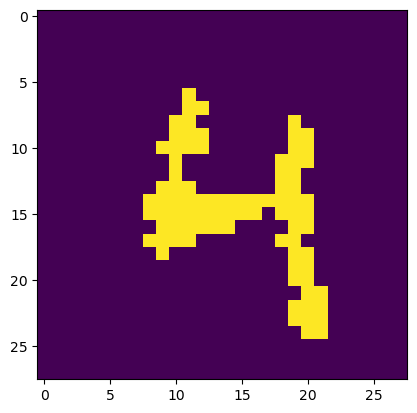

In [7]:
input_batch = next(iter(train_loader))[0][0,:].unsqueeze(0)
input_batch = input_batch.to(device)
plt.imshow(input_batch[0, :].cpu().detach().squeeze().numpy())

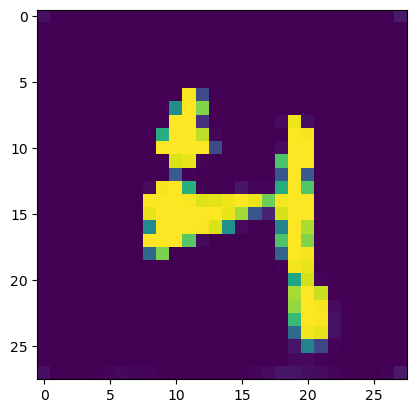

In [8]:
plt.imshow(model(input_batch)[0, :].cpu().detach().squeeze().numpy())

Your task is to write a function that for a given input image and output pixel coordinates produces a list of input pixels that have non-zero contribution to the value of the output pixel. You should measure each pixel's contribution by setting it to the minimal and maximal value over the whole image.

In [9]:
def important_pixels(input_batch: torch.Tensor, model: torchvision.models.segmentation.fcn.FCN, device: torch.device, coordinates: typing.Tuple[int, int]) -> typing.Set[typing.Tuple[int,int]]: 
    model = model.to(device)
    input_batch = input_batch.to(device)

    ################################
    output = model(input_batch)
    pixels = []

    y, x = coordinates    

    for height in range(input_batch.shape[2]):
        for width in range(input_batch.shape[3]):
            max_img = input_batch.clone()
            min_img = input_batch.clone()

            max_img[0][0][height][width] = input_batch.max()
            min_img[0][0][height][width] = input_batch.min()

            output_max = model(max_img)
            output_min = model(min_img)

            max_imp = abs(output_max[0][0][y][x] - output[0][0][y][x])
            min_imp = abs(output_min[0][0][y][x] - output[0][0][y][x])

            imp = max_imp + min_imp

            if imp != 0:
                pixels.append([height, width])

    return pixels
            

    ################################



In [10]:
checked_pixel = (0, 0)
pixels = important_pixels(input_batch, model, device, checked_pixel)

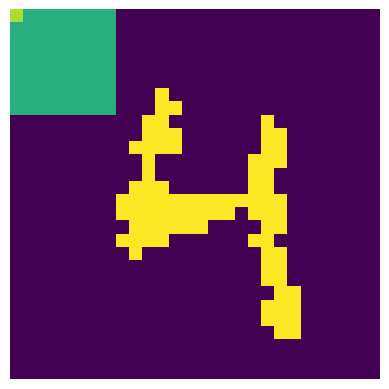

In [11]:
input_image_numpy = input_batch[0, :].cpu().detach().squeeze().numpy()

for pixel in pixels:
    input_image_numpy[pixel[0], pixel[1]] = 0.25

input_image_numpy[checked_pixel[0], checked_pixel[1]] = 0.75

plt.imshow(input_image_numpy)
plt.axis("off")
plt.show()